# HighResMIP (CM6 and CM7)

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
xr.__version__

'0.16.0'

## Define paths

In [3]:
exp_ref = 'IPSL-CM6A-ATM-HR'
exp_new = 'CM7A-HR-v1.11.highresSST-present'

In [4]:
latlim, lonlim = u.get_domain_HMA()
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

In [5]:
# !ls /thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/LMDZOR-STD-REF/ATM/Analyse/TS_MO/

## Make function to get data

In [10]:
def get_data(list_vars, period, season, zone):
    """
        Get reference and new experiments + observations.

        Parameters
        ----------
        list_vars : list
            List of variables. Options are: 'frac_snow', 't2m', 'precip', 'ta'
        period : slice
            Period
        season : str
            Season (ex: 'annual', 'DJF', '1')
        zone : str
            Zone of study (ex: 'HMA', 'GLOB', 'NH')

        Returns
        -------
        ref, new, obs : list of Dataset
            List of reference and new experiments + observations regrided on model dataset (not 
            loaded) for each variable.
            
        clim_ref, clim_new, clim_obs : list of DataArray
            List of reference and new experiments + observations regrided on model climatologies
            for each variable.

        Example
        -------
        >>>  list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
                ['frac_snow', 't2m', 'precip'], slice('1981','1989'), 'annual', 'GLOB'
            )

    """
    
    list_ref = []
    list_new = []
    list_obs = []
    list_clim_ref = []
    list_clim_new = []
    list_clim_obs = []
       
    list_var_SRF = ['frac_snow']
    list_var_ATM = ['t2m', 'precip', 'ta']
    latlim, lonlim = u.get_zone(zone)

    for var in list_vars:

        print(
            f"""
    #############
    ### Variable: {var} 
    #############
            """
        )

        if var in list_var_SRF:
            component = 'SRF'
            component_ref = 'LImon'
        elif var in list_var_ATM:
            component = 'ATM'
            component_ref = 'Amon'
        else:
            raise ValueError(f"Invalid var argument: '{var}'. Valid names are: 'frac_snow'.")

        if var == 'frac_snow':
            var_ref = 'snc'
        elif var == 't2m':
            var_ref = 'tas'
        elif var == 'precip':
            var_ref = 'pr'
        
        path = '/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/'+component_ref+'/'+var_ref+'/gr/latest/'+var_ref+'_'+component_ref+'_IPSL-CM6A-ATM-HR_highresSST-present_r1i1p1f1_gr_195001-201412.nc'
        print('Open reference simulation:\n'+path+'\n')
        ref = xr.open_dataset(path)[var_ref]
        ref.attrs['title'] = exp_ref

        path = '/thredds/tgcc/store/p86caub/ICOLMDZOR/PROD/highresSST-present/CM7A-HR-v1.11.highresSST-present/'+component+'/Analyse/TS_MO/'+exp_new+'_19500101_20141231_1M_'+var+'.nc'
        print('Open new simulation:\n'+path+'\n')
        new = xr.open_dataset(path)[var]
        
        # Regrid CM7 on CM6
        regridder_CM7 = xe.Regridder(new, ref, 'bilinear', periodic=False, reuse_weights=False)
        new = regridder_CM7(new)
        
        new.attrs['title'] = exp_new

        # Rename time dimension and sort latitude from -90 to 90
#         ref = ref.rename({'time_counter': 'time'}).sortby('lat')
#         new = new.rename({'time_counter': 'time'}).sortby('lat')
        new = new.rename({'time_counter': 'time'})
    

        # Compute climatolgy
        clim_ref = u.clim(
            ref.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='360_day')
        clim_ref.attrs['season'] = season
        clim_ref.attrs['zone'] = zone

        clim_new = u.clim(
            new.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='360_day')
        clim_new.attrs['season'] = season
        clim_new.attrs['zone'] = zone

        # Unit conversion
        if var in ['tas', 'tmp', 't2m', 'ta']:
            with xr.set_options(keep_attrs=True):
                clim_ref -= 273.15
                clim_new -= 273.15
            clim_ref.attrs['units'] = '°C'
            clim_new.attrs['units'] = '°C'

            if var in ['ta']:
                clim_ref = clim_ref.assign_coords({'plev': clim_ref.plev/100}).rename({'plev': 'level'})
                clim_new = clim_new .assign_coords({'plev': clim_new.plev/100}).rename({'plev': 'level'})

        elif var in ['pr', 'precip']:
            with xr.set_options(keep_attrs=True):
                clim_ref *= 86400
                clim_new *= 86400
            clim_ref.attrs['units'] = 'mm/day'
            clim_new.attrs['units'] = 'mm/day'

        # Get observations
        if var in ['snc', 'frac_snow']:
            obs_name = 'NH_SCE_CDR_HR'
            version = 'v01r00'
        elif var in ['tas', 'tmp', 't2m']:
            obs_name = 'CRU_TS'
            version = '4.04'
        elif var in ['pr', 'precip']:
            obs_name = 'APHRO_MA'
            version = 'V1101'
        elif var in ['ta']:
            obs_name = 'ERAI'
            version = ''

        obs = u.get_obs(obs_name, version, var, period=period, machine='CICLAD', regrid=clim_ref)
        clim_obs = u.clim(
            obs.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='standard')
        
        
        list_ref.append(ref)
        list_new.append(new)
        list_obs.append(obs)
        list_clim_ref.append(clim_ref)
        list_clim_new.append(clim_new)
        list_clim_obs.append(clim_obs)
               
    return list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs

## Plot differences and compare to observation

### HMA

#### Get data

In [11]:
# list_vars = ['frac_snow']
list_vars = ['frac_snow', 't2m', 'precip']

# Period for climatologies (removing first year spin-up)
period = slice('1981','1998')
season = 'annual'
zone = 'HMA'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)


    #############
    ### Variable: frac_snow 
    #############
            
Open reference simulation:
/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/LImon/snc/gr/latest/snc_LImon_IPSL-CM6A-ATM-HR_highresSST-present_r1i1p1f1_gr_195001-201412.nc

Open new simulation:
/thredds/tgcc/store/p86caub/ICOLMDZOR/PROD/highresSST-present/CM7A-HR-v1.11.highresSST-present/SRF/Analyse/TS_MO/CM7A-HR-v1.11.highresSST-present_19500101_20141231_1M_frac_snow.nc

Create weight file: bilinear_360x720_361x512.nc
Get observation: NH_SCE_CDR_HR
/data/mlalande/RUTGERS/G10035-rutgers-nh-24km-weekly-sce-v01r00-19800826-20200831_newer_without_xy.nc



/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Reuse existing file: bilinear_709x709_61x71_peri.nc

    #############
    ### Variable: t2m 
    #############
            
Open reference simulation:
/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/Amon/tas/gr/latest/tas_Amon_IPSL-CM6A-ATM-HR_highresSST-present_r1i1p1f1_gr_195001-201412.nc

Open new simulation:
/thredds/tgcc/store/p86caub/ICOLMDZOR/PROD/highresSST-present/CM7A-HR-v1.11.highresSST-present/ATM/Analyse/TS_MO/CM7A-HR-v1.11.highresSST-present_19500101_20141231_1M_t2m.nc

Overwrite existing file: bilinear_360x720_361x512.nc 
 You can set reuse_weights=True to save computing time.
Get observation: CRU_TS
/data/mlalande/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc

Reuse existing file: bilinear_360x720_61x71_peri.nc

    #############
    ### Variable: precip 
    #############
            
Open reference simulation:
/bdd/CMIP6/HighResMIP/IPSL/IPSL-CM6A-ATM-HR/highresSST-present/r1i1p1f1/Amon/pr/gr/latest/pr_Amon_IPSL-CM6A-ATM-HR_highresSST-present_r1i1p1f

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_140x180_61x71.nc


#### Make plots

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


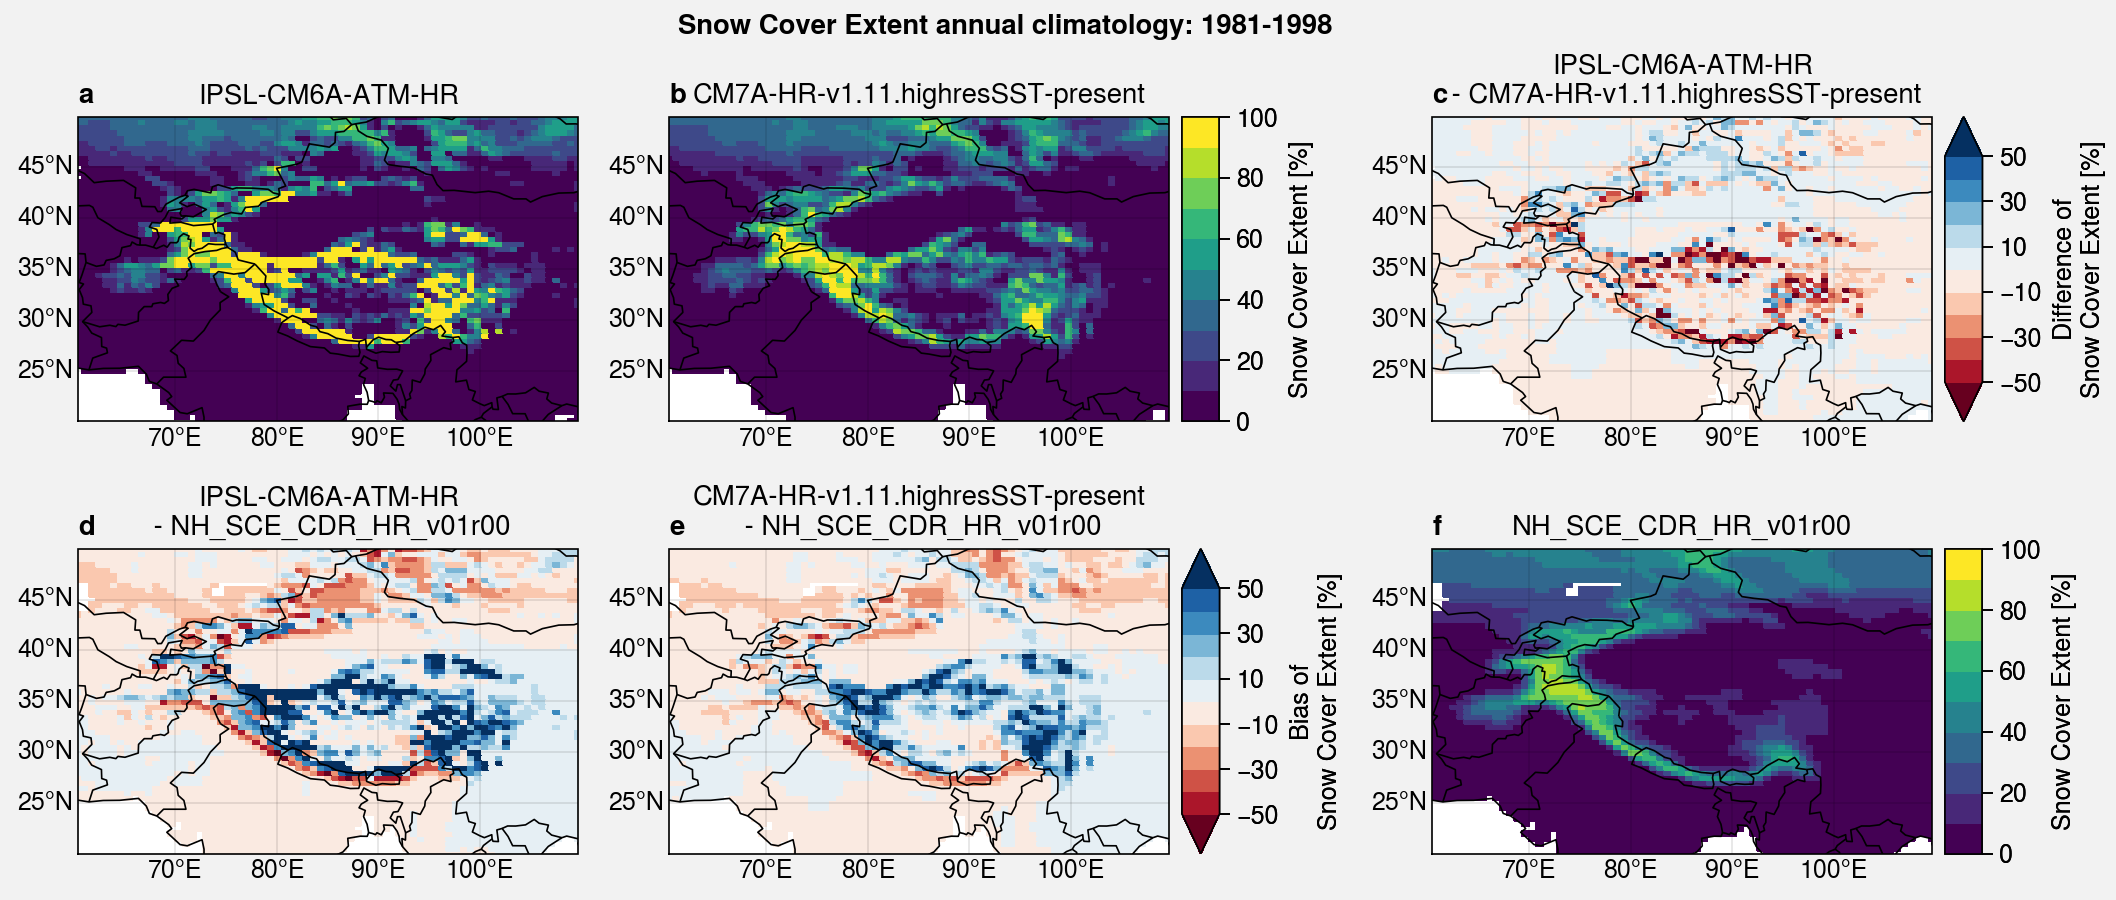

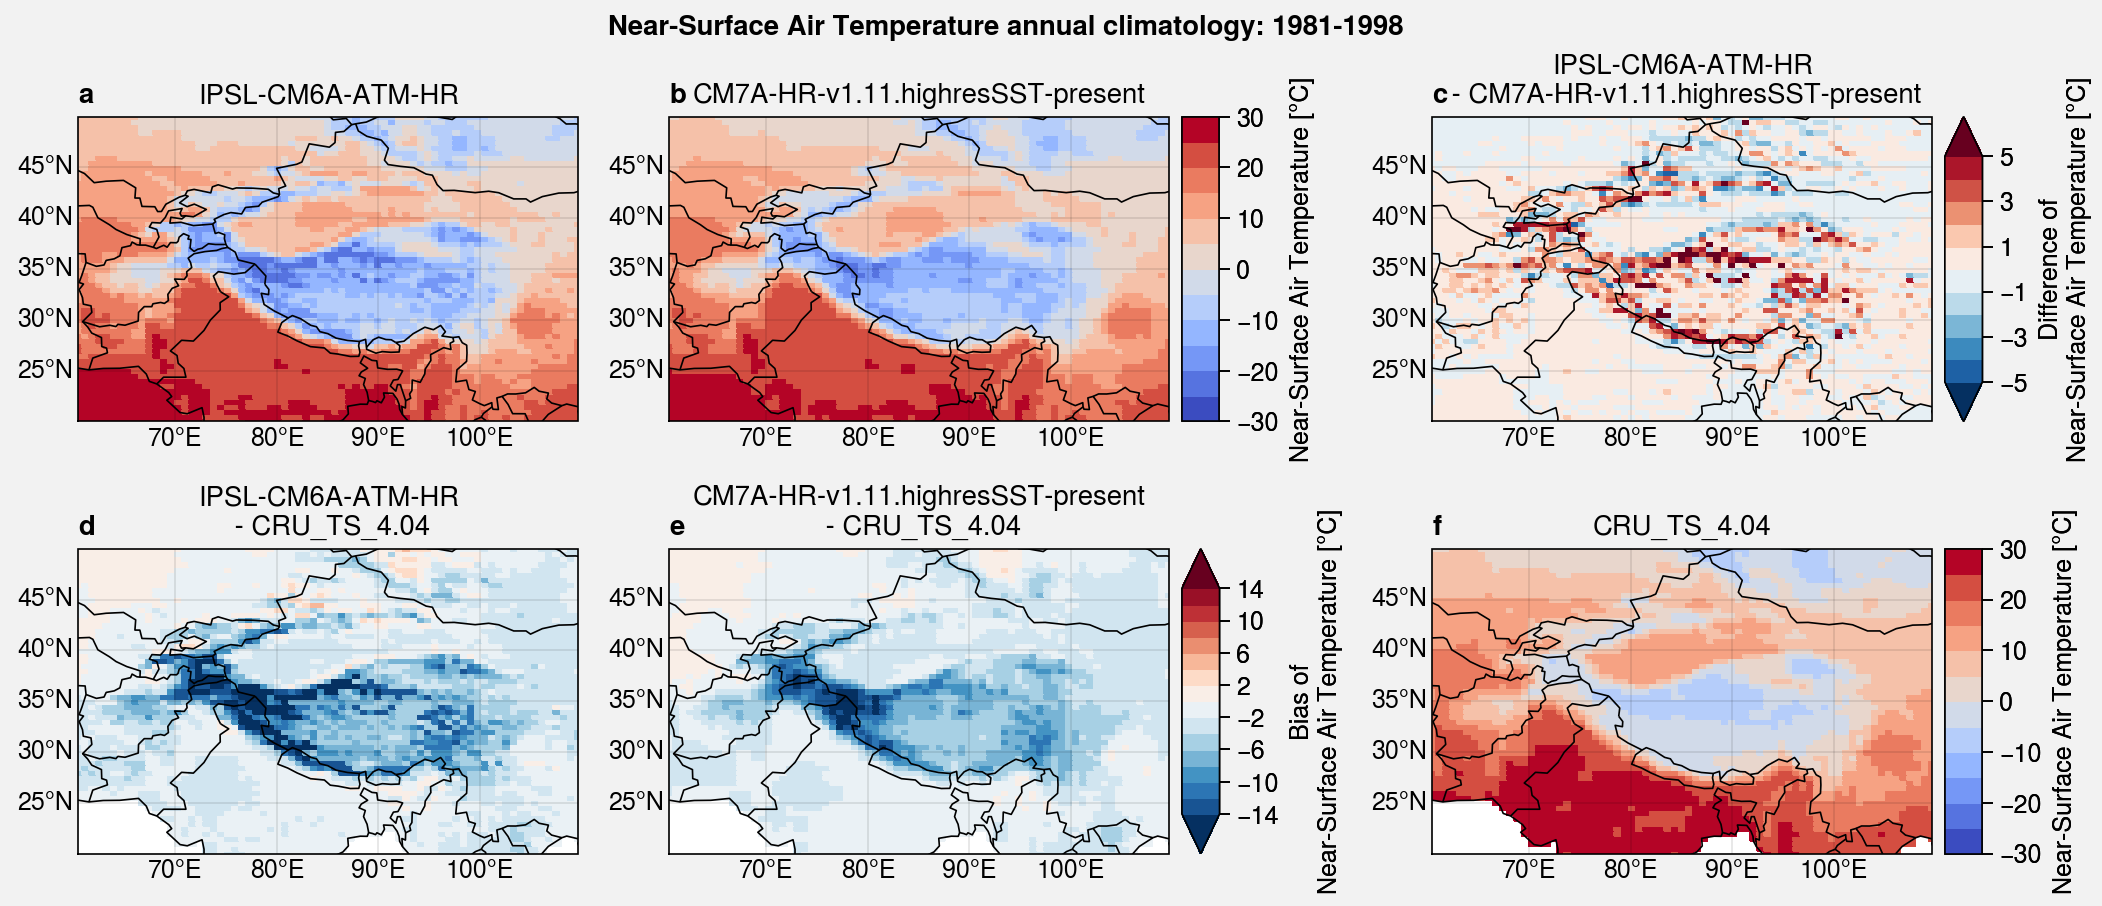

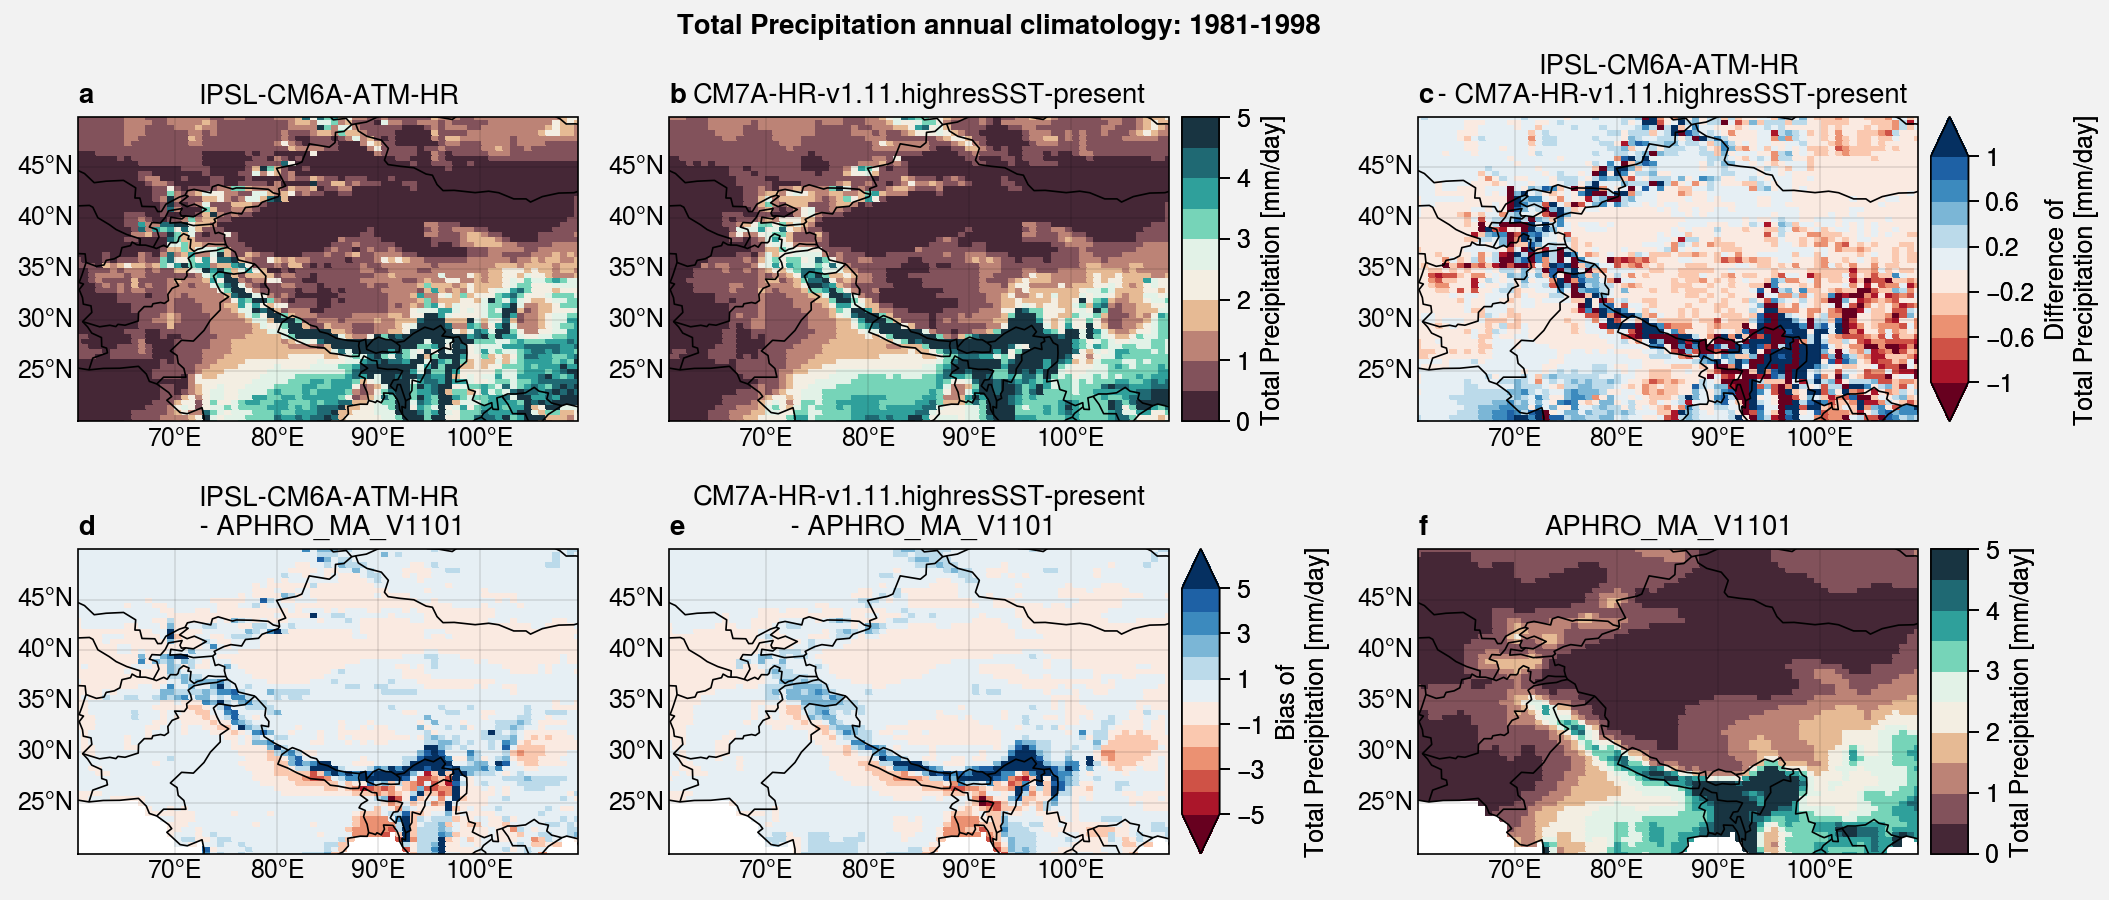

In [13]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_ref_new_obs(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels, cmap, extend,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=True, dpi=300
    )

### Northern Hemisphere

#### Get data

In [ ]:
# list_vars = ['frac_snow']
list_vars = ['frac_snow', 't2m']

# Period for climatologies (removing first year spin-up)
period = slice('1981','1998')
season = 'annual'
zone = 'NH'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)

#### Make plots

In [ ]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_ref_new_obs(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels, cmap, extend,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=False, dpi=300
    )

## Check correlation with topo

In [14]:
ds = xr.open_dataset('/data/mlalande/GMTED2010/GMTED2010_15n120_0500deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

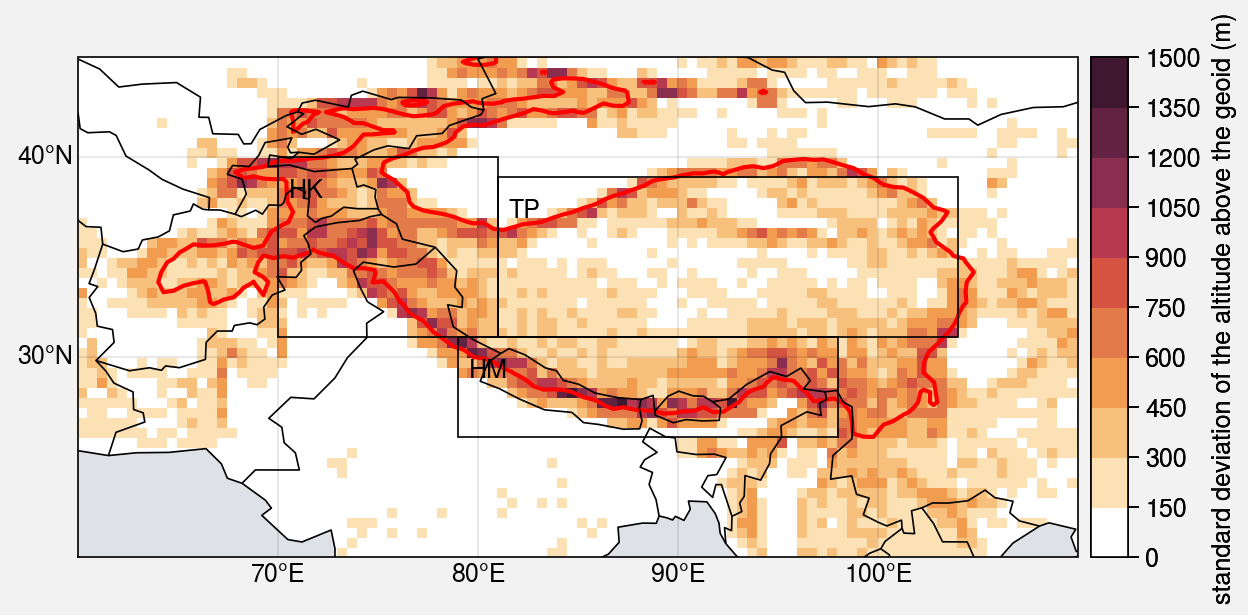

In [21]:
fig, axs = plot.subplots(proj='cyl', axwidth=5)

axs[0].pcolormesh(elevation_std, colorbar='r')

u.plot_zones(axs[0])
axs[0].contour(elevation, levels=[2500], color='red')

axs.format(
    labels=True, coast=True, ocean=True, oceancolor='gray3', borders=True,
    lonlines=10, latlines=10, latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

fig.save('img/std.jpg')

In [16]:
elevation_std_regrid = u.regrid(elevation_std, list_ref[0], globe=False, periodic=False)
elevation_regrid = u.regrid(elevation, list_ref[0], globe=False, periodic=False)

Create weight file: bilinear_70x120_361x512.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_70x120_361x512.nc


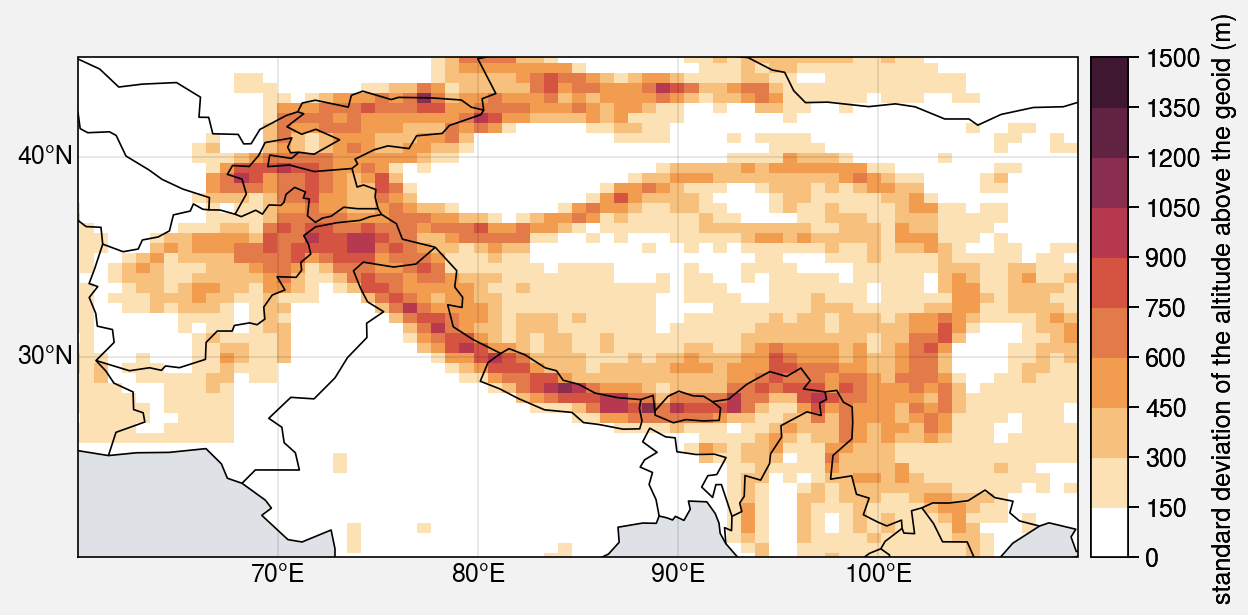

In [18]:
fig, axs = plot.subplots(proj='cyl', axwidth=5)

axs[0].pcolormesh(elevation_std_regrid, colorbar='r', levels=plot.arange(0,1500,150))

axs.format(
    labels=True, coast=True, ocean=True, oceancolor='gray3', borders=True,
    lonlines=10, latlines=10, latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop)
)

In [19]:
std = elevation_std_regrid.sel(lon=lonlim, lat=latlim).values.flatten()
topo = elevation_regrid.sel(lon=lonlim, lat=latlim).values.flatten()
ref_snc = (list_clim_ref[0] - list_clim_obs[0]).sel(lon=lonlim, lat=latlim).values.flatten()
new_snc = (list_clim_new[0] - list_clim_obs[0]).sel(lon=lonlim, lat=latlim).values.flatten()
ref_tas = (list_clim_ref[1] - list_clim_obs[1]).sel(lon=lonlim, lat=latlim).values.flatten()
new_tas = (list_clim_new[1] - list_clim_obs[1]).sel(lon=lonlim, lat=latlim).values.flatten()
ref_pr = (list_clim_ref[2] - list_clim_obs[2]).sel(lon=lonlim, lat=latlim).values.flatten()
new_pr = (list_clim_new[2] - list_clim_obs[2]).sel(lon=lonlim, lat=latlim).values.flatten()

std = np.array(std)
topo = np.array(topo)
ref_snc = np.array(ref_snc)
new_snc = np.array(new_snc)
ref_tas = np.array(ref_tas)
new_tas = np.array(new_tas)
ref_pr = np.array(ref_pr)
new_pr = np.array(new_pr)

# Remove NaNs (because of ocean)
std = std[~np.isnan(ref_snc)]
topo = topo[~np.isnan(ref_snc)]
new_snc = new_snc[~np.isnan(ref_snc)]
new_tas = new_tas[~np.isnan(ref_snc)]
ref_tas = ref_tas[~np.isnan(ref_snc)]
new_pr = new_pr[~np.isnan(ref_snc)]
ref_pr = ref_pr[~np.isnan(ref_snc)]

ref_snc = ref_snc[~np.isnan(ref_snc)]


std = std[~np.isnan(ref_tas)]
topo = topo[~np.isnan(ref_tas)]
new_snc = new_snc[~np.isnan(ref_tas)]
new_tas = new_tas[~np.isnan(ref_tas)]
ref_snc = ref_snc[~np.isnan(ref_tas)]
new_pr = new_pr[~np.isnan(ref_tas)]
ref_pr = ref_pr[~np.isnan(ref_tas)]

ref_tas = ref_tas[~np.isnan(ref_tas)]


print(len(std))
print(len(topo))
print(len(new_snc))
print(len(ref_snc))
print(len(new_tas))
print(len(ref_tas))
print(len(new_pr))
print(len(ref_pr))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


3397
3397
3397
3397
3397
3397
3397
3397


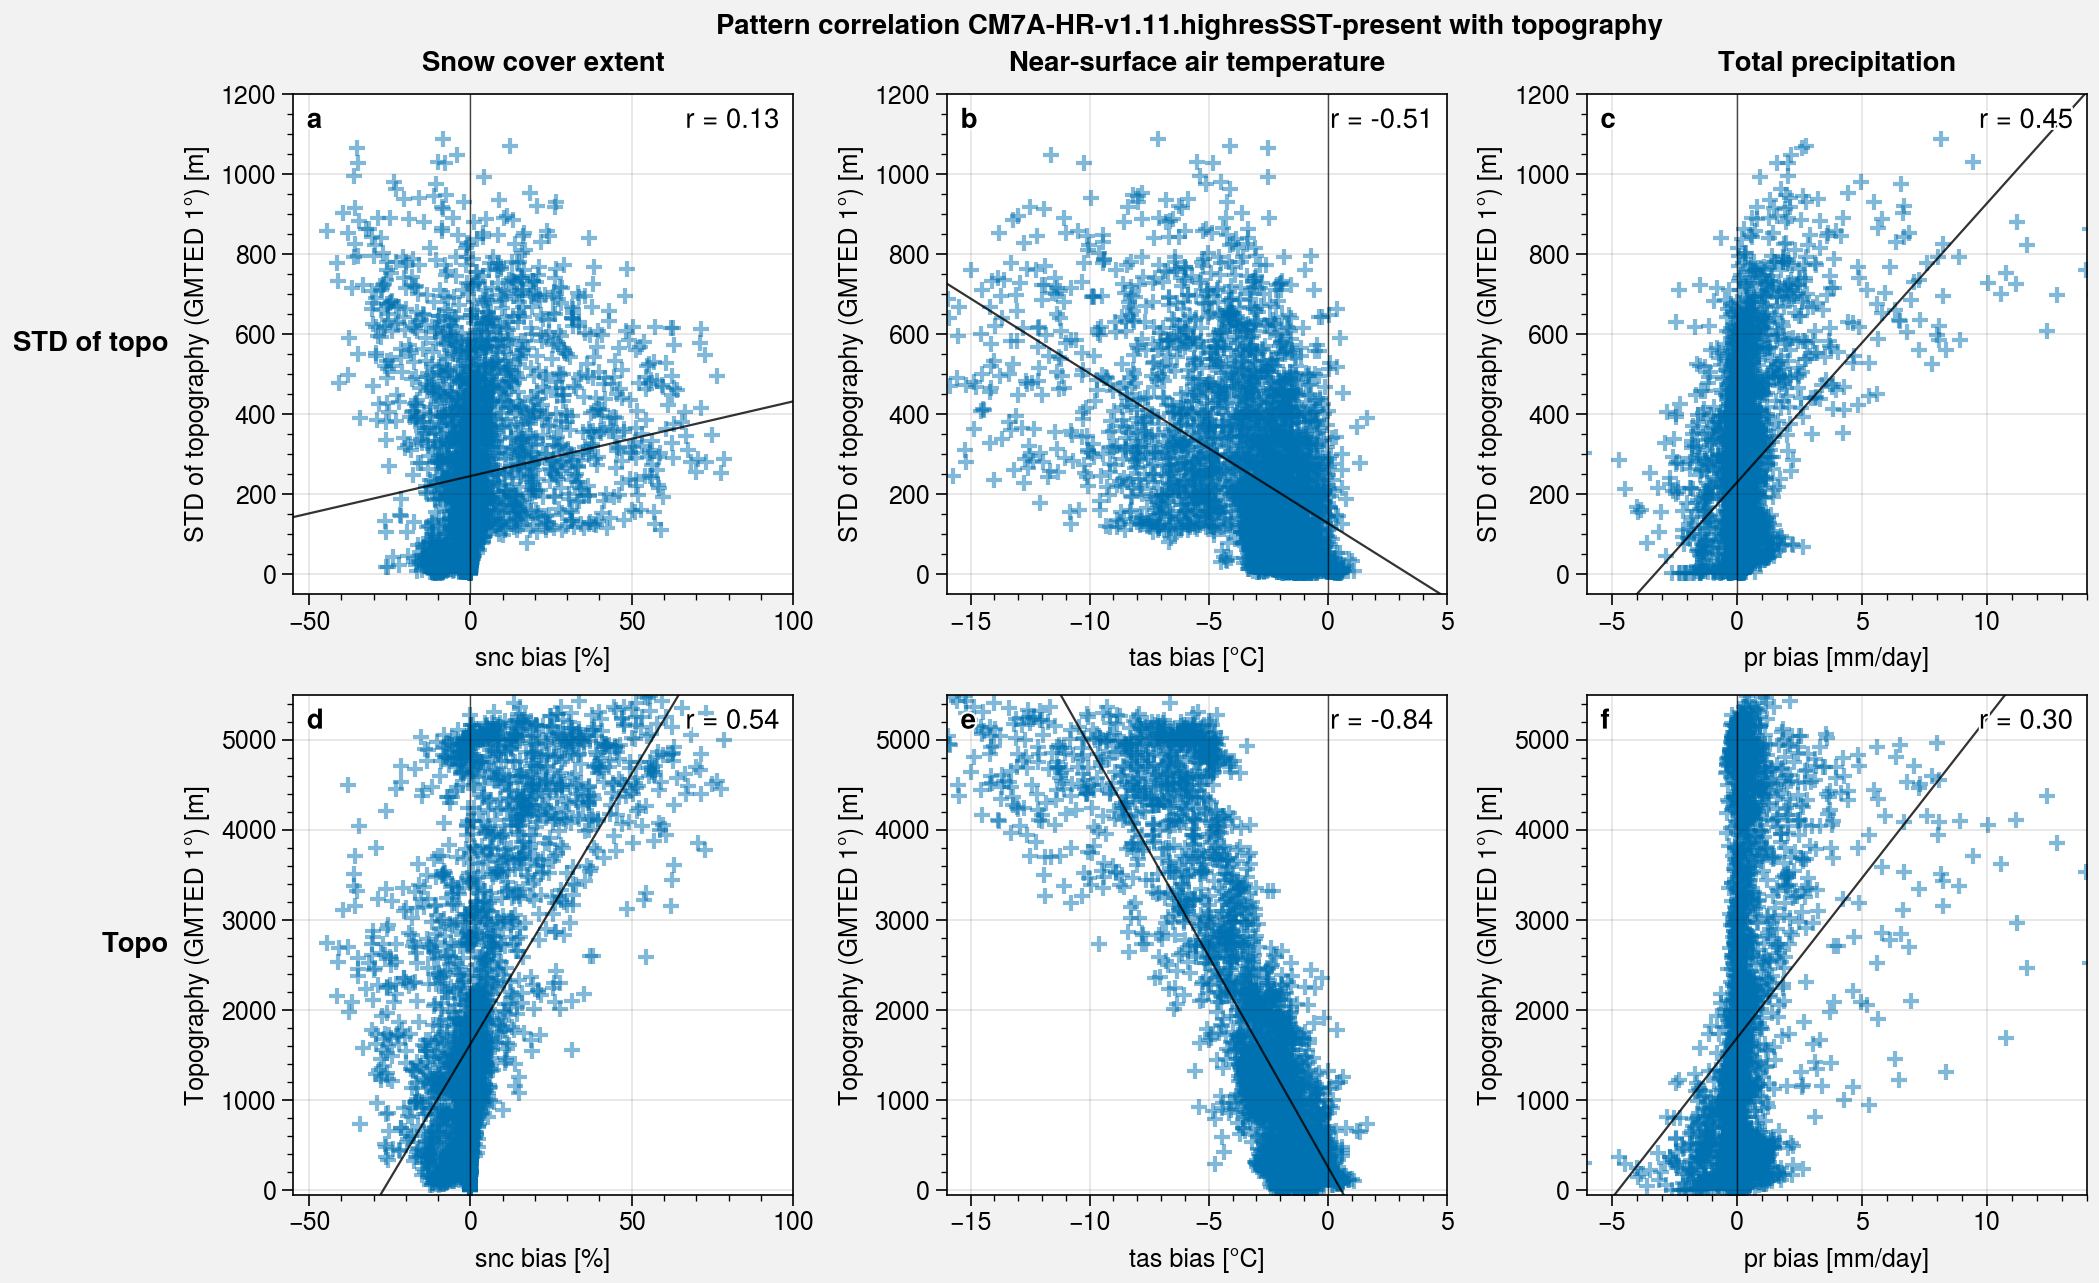

In [31]:
xlim_snc = (-55,100)
xlim_tas = (-16,5)
xlim_pr = (-6,14)
ylim_std = (-50,1200)
ylim_topo = (-50,5500)

x_list = [new_snc, new_tas, new_pr]*2
x_lim_list = [xlim_snc, xlim_tas, xlim_pr]*2
x_label_list = ['snc bias [%]', 'tas bias [°C]', 'pr bias [mm/day]']*2

y_list = [std for _ in range(len(x_list)//2)] + [topo for _ in range(len(x_list)//2)]
y_lim_list = [ylim_std for _ in range(len(x_list)//2)] + [ylim_topo for _ in range(len(x_list)//2)]
y_label_list = ['STD of topography' for _ in range(len(x_list)//2)] + ['Topography' for _ in range(len(x_list)//2)]



fig, axs = plot.subplots(ncols=3, nrows=2, share=0)

for i, ax in enumerate(axs):
    # Scatter plot
    ax.scatter(x_list[i], y_list[i], marker='+', alpha=0.5)

    # Regression
    reg = stats.linregress(x_list[i], y_list[i])
    x = np.array(x_lim_list[i])
    y = reg.slope*x + reg.intercept
    ax.plot(x, y, 'k-', linewidth=0.8, alpha=0.8)
    
    # Add vertical line 
    ax.plot([0, 0], y_lim_list[i], color='k', linestyle='-', alpha=0.7, linewidth=0.5)

    # Format
    ax.format(
        urtitle='r = '+'{:.2f}'.format(reg.rvalue),
        xlabel=x_label_list[i], ylabel=y_label_list[i]+' (GMTED 1°) [m]', 
        ylim=y_lim_list[i], xlim=x_lim_list[i]
    )
    

##############
### Format ###
##############

axs.format(
    suptitle='Pattern correlation '+exp_new+' with topography',
    collabels=['Snow cover extent', 'Near-surface air temperature', 'Total precipitation'],
    rowlabels=['STD of topo', 'Topo'],
    abc=True, abcloc='ul'
)

fig.save('img/CM7A-HR-v1.11.highresSST-present/corr_topo_HR.jpg')

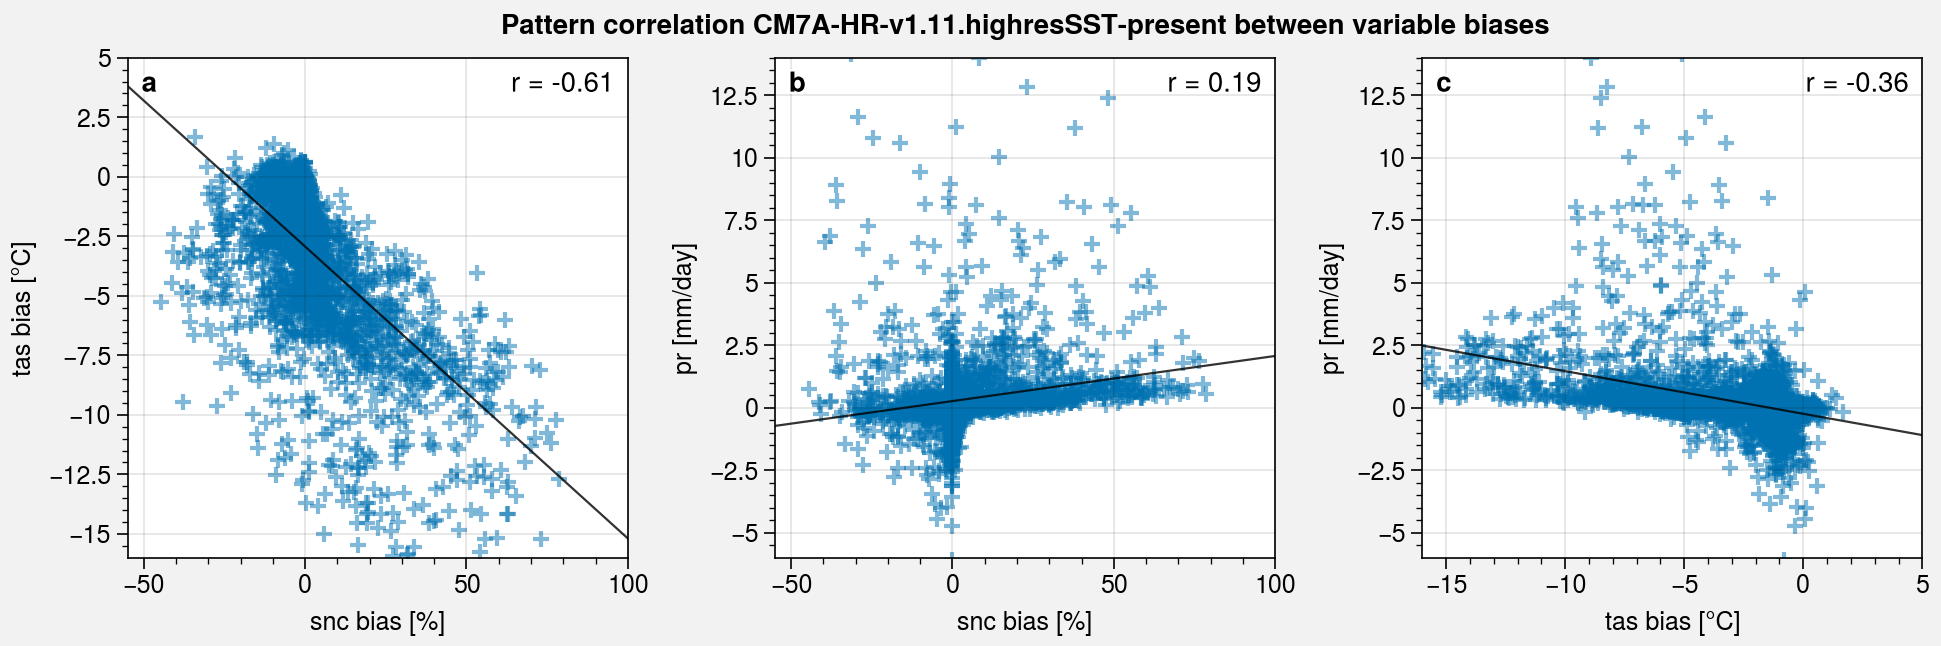

In [23]:
xlim_snc = (-55,100)
xlim_tas = (-16,5)
xlim_pr = (-6,14)
ylim_std = (-50,1200)
ylim_topo = (-50,5500)

x_list = [new_snc, new_snc, new_tas]
x_lim_list = [xlim_snc, xlim_snc, xlim_tas]
x_label_list = ['snc bias [%]', 'snc bias [%]', 'tas bias [°C]']

y_list = [new_tas, new_pr, new_pr]
y_lim_list = [xlim_tas, xlim_pr, xlim_pr]
y_label_list = ['tas bias [°C]', 'pr [mm/day]', 'pr [mm/day]']



fig, axs = plot.subplots(ncols=3, nrows=1, share=0)

for i, ax in enumerate(axs):
    # Scatter plot
    ax.scatter(x_list[i], y_list[i], marker='+', alpha=0.5)

    # Regression
    reg = stats.linregress(x_list[i], y_list[i])
    x = np.array(x_lim_list[i])
    y = reg.slope*x + reg.intercept
    ax.plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

    # Format
    ax.format(
        urtitle='r = '+'{:.2f}'.format(reg.rvalue),
        xlabel=x_label_list[i], ylabel=y_label_list[i], 
        ylim=y_lim_list[i], xlim=x_lim_list[i]
    )
    

##############
### Format ###
##############

axs.format(
    suptitle='Pattern correlation '+exp_new+' between variable biases',
    abc=True, abcloc='ul'
)

# fig.save('img/COR2mEg/corr_var.jpg')

In [60]:
lonlim = zones_df.lonlim['HM']
latlim = zones_df.latlim['HM']

std = elevation_std_regrid.sel(lon=lonlim, lat=latlim).values.flatten()
topo = elevation_regrid.sel(lon=lonlim, lat=latlim).values.flatten()
ref_snc = (list_clim_ref[0] - list_clim_obs[0]).sel(lon=lonlim, lat=latlim).values.flatten()
new_snc = (list_clim_new[0] - list_clim_obs[0]).sel(lon=lonlim, lat=latlim).values.flatten()
ref_tas = (list_clim_ref[1] - list_clim_obs[1]).sel(lon=lonlim, lat=latlim).values.flatten()
new_tas = (list_clim_new[1] - list_clim_obs[1]).sel(lon=lonlim, lat=latlim).values.flatten()
ref_pr = (list_clim_ref[2] - list_clim_obs[2]).sel(lon=lonlim, lat=latlim).values.flatten()
new_pr = (list_clim_new[2] - list_clim_obs[2]).sel(lon=lonlim, lat=latlim).values.flatten()

std = np.array(std)
topo = np.array(topo)
ref_snc = np.array(ref_snc)
new_snc = np.array(new_snc)
ref_tas = np.array(ref_tas)
new_tas = np.array(new_tas)
ref_pr = np.array(ref_pr)
new_pr = np.array(new_pr)

# Remove NaNs (because of ocean)
std = std[~np.isnan(ref_snc)]
topo = topo[~np.isnan(ref_snc)]
new_snc = new_snc[~np.isnan(ref_snc)]
new_tas = new_tas[~np.isnan(ref_snc)]
ref_tas = ref_tas[~np.isnan(ref_snc)]
new_pr = new_pr[~np.isnan(ref_snc)]
ref_pr = ref_pr[~np.isnan(ref_snc)]

ref_snc = ref_snc[~np.isnan(ref_snc)]


std = std[~np.isnan(ref_tas)]
topo = topo[~np.isnan(ref_tas)]
new_snc = new_snc[~np.isnan(ref_tas)]
new_tas = new_tas[~np.isnan(ref_tas)]
ref_snc = ref_snc[~np.isnan(ref_tas)]
new_pr = new_pr[~np.isnan(ref_tas)]
ref_pr = ref_pr[~np.isnan(ref_tas)]

ref_tas = ref_tas[~np.isnan(ref_tas)]


print(len(std))
print(len(topo))
print(len(new_snc))
print(len(ref_snc))
print(len(new_tas))
print(len(ref_tas))
print(len(new_pr))
print(len(ref_pr))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


104
104
104
104
104
104
104
104


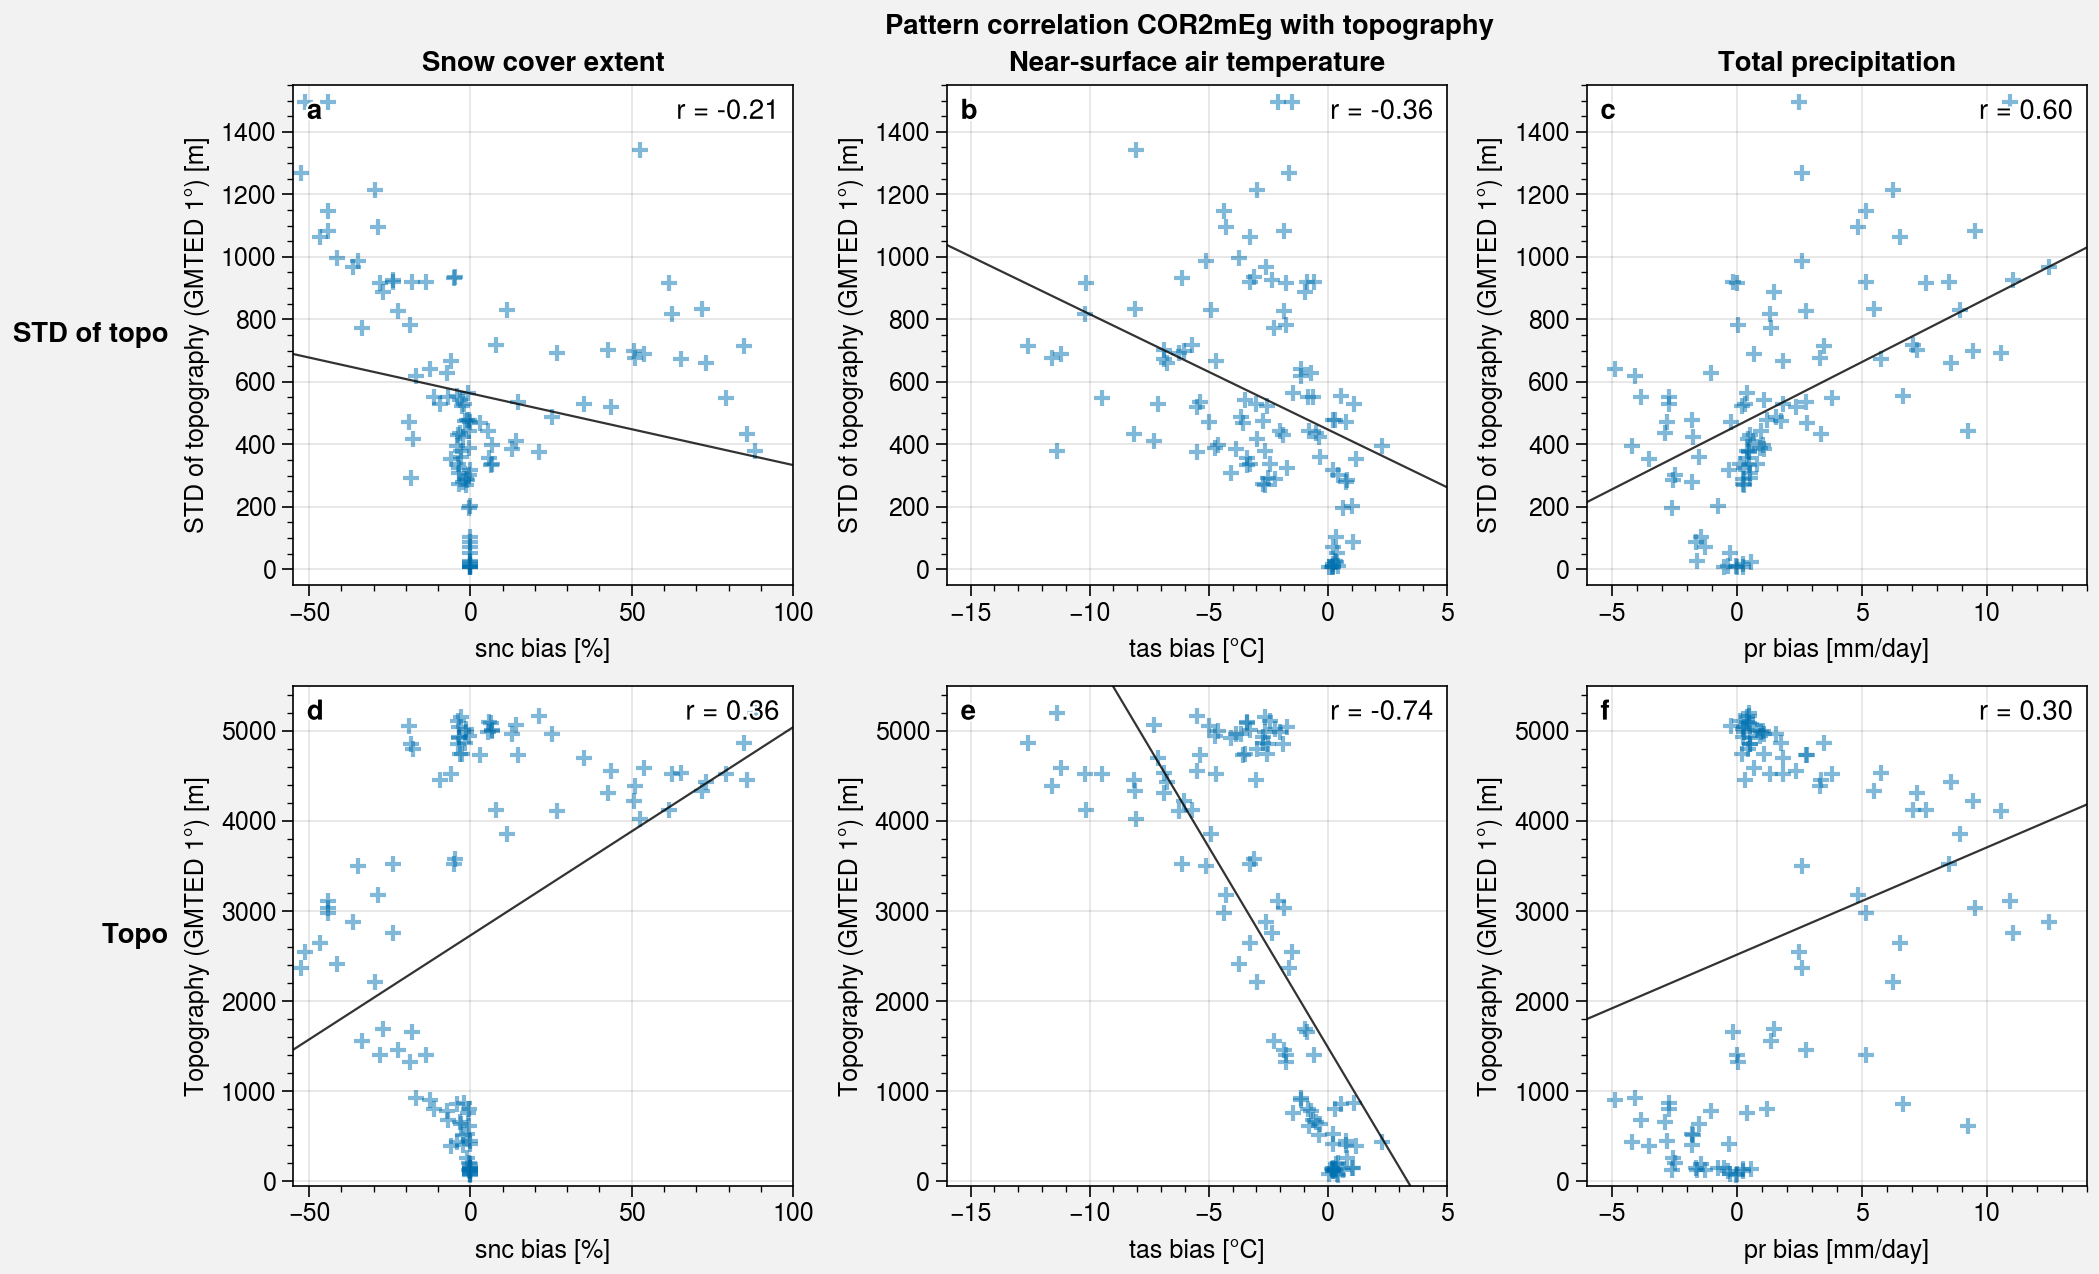

In [61]:
xlim_snc = (-55,100)
xlim_tas = (-16,5)
xlim_pr = (-6,14)
ylim_std = (-50,1550)
ylim_topo = (-50,5500)

x_list = [new_snc, new_tas, new_pr]*2
x_lim_list = [xlim_snc, xlim_tas, xlim_pr]*2
x_label_list = ['snc bias [%]', 'tas bias [°C]', 'pr bias [mm/day]']*2

y_list = [std for _ in range(len(x_list)//2)] + [topo for _ in range(len(x_list)//2)]
y_lim_list = [ylim_std for _ in range(len(x_list)//2)] + [ylim_topo for _ in range(len(x_list)//2)]
y_label_list = ['STD of topography' for _ in range(len(x_list)//2)] + ['Topography' for _ in range(len(x_list)//2)]



fig, axs = plot.subplots(ncols=3, nrows=2, share=0)

for i, ax in enumerate(axs):
    # Scatter plot
    ax.scatter(x_list[i], y_list[i], marker='+', alpha=0.5)

    # Regression
    reg = stats.linregress(x_list[i], y_list[i])
    x = np.array(x_lim_list[i])
    y = reg.slope*x + reg.intercept
    ax.plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

    # Format
    ax.format(
        urtitle='r = '+'{:.2f}'.format(reg.rvalue),
        xlabel=x_label_list[i], ylabel=y_label_list[i]+' (GMTED 1°) [m]', 
        ylim=y_lim_list[i], xlim=x_lim_list[i]
    )
    

##############
### Format ###
##############

axs.format(
    suptitle='Pattern correlation '+exp_new+' with topography',
    collabels=['Snow cover extent', 'Near-surface air temperature', 'Total precipitation'],
    rowlabels=['STD of topo', 'Topo'],
    abc=True, abcloc='ul'
)

# fig.save('img/COR2mEg/corr_topo.jpg')

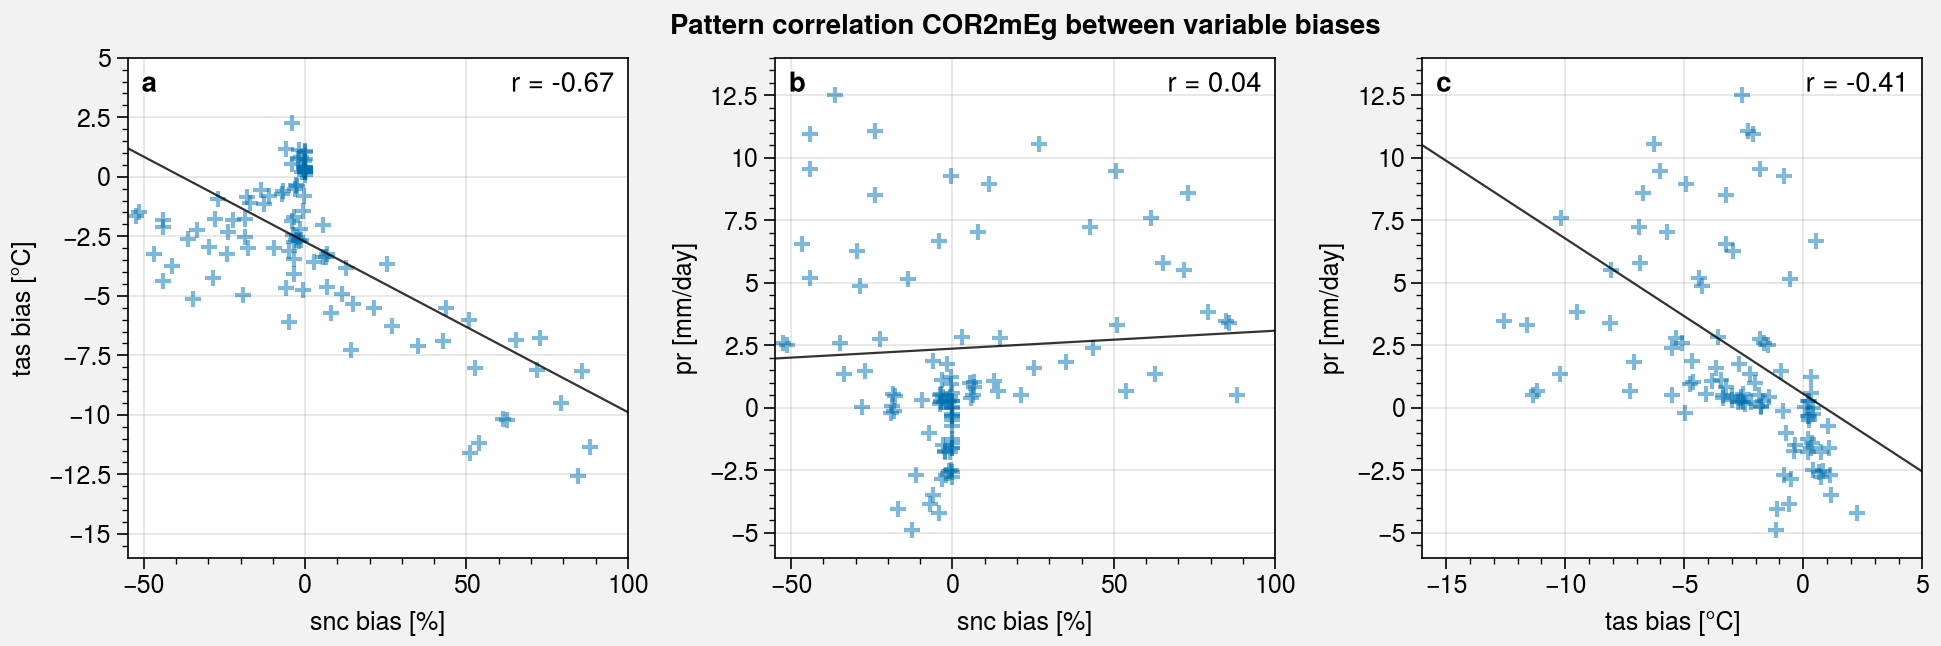

In [62]:
xlim_snc = (-55,100)
xlim_tas = (-16,5)
xlim_pr = (-6,14)
ylim_std = (-50,1550)
ylim_topo = (-50,5500)

x_list = [new_snc, new_snc, new_tas]
x_lim_list = [xlim_snc, xlim_snc, xlim_tas]
x_label_list = ['snc bias [%]', 'snc bias [%]', 'tas bias [°C]']

y_list = [new_tas, new_pr, new_pr]
y_lim_list = [xlim_tas, xlim_pr, xlim_pr]
y_label_list = ['tas bias [°C]', 'pr [mm/day]', 'pr [mm/day]']



fig, axs = plot.subplots(ncols=3, nrows=1, share=0)

for i, ax in enumerate(axs):
    # Scatter plot
    ax.scatter(x_list[i], y_list[i], marker='+', alpha=0.5)

    # Regression
    reg = stats.linregress(x_list[i], y_list[i])
    x = np.array(x_lim_list[i])
    y = reg.slope*x + reg.intercept
    ax.plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

    # Format
    ax.format(
        urtitle='r = '+'{:.2f}'.format(reg.rvalue),
        xlabel=x_label_list[i], ylabel=y_label_list[i], 
        ylim=y_lim_list[i], xlim=x_lim_list[i]
    )
    

##############
### Format ###
##############

axs.format(
    suptitle='Pattern correlation '+exp_new+' between variable biases',
    abc=True, abcloc='ul'
)

# fig.save('img/COR2mEg/corr_var.jpg')